In [1]:
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc)

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(), df.shape, df.dtypes

(   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovies      

In [4]:
# clean “TotalCharges” (object → numeric) + drop bad rows
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df = df.dropna(subset=["TotalCharges"]).reset_index(drop=True)

In [5]:
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

In [6]:
# create target (Churn) and separate features / target
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})
y = df["Churn"].values
X = df.drop(columns=["Churn"])

In [7]:
# one-hot encode all categorical features (drop first to avoid multicollinearity)
X_encoded = pd.get_dummies(X, drop_first=True)
X_encoded.shape, X_encoded.columns[:10]

((7032, 30),
 Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
        'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
        'MultipleLines_No phone service', 'MultipleLines_Yes'],
       dtype='object'))

In [8]:
# train/test split (80/20) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
# tandardize numeric features (fit on train only → transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Keep the feature names for interpretation later
feature_names = X_encoded.columns.tolist()


In [9]:
# Part 2 — Baseline: Logistic Regression + coefficient interpretation
# train logistic regression (baseline)
log_reg = LogisticRegression(max_iter=2000, solver="liblinear", random_state=42)
log_reg.fit(X_train_scaled, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)


In [10]:
# extract and visualize coefficients (top positive / top negative)
coef = pd.Series(log_reg.coef_.ravel(), index=feature_names).sort_values(ascending=False)

top_pos = coef.head(10)   # increases churn risk
top_neg = coef.tail(10)   # decreases churn risk


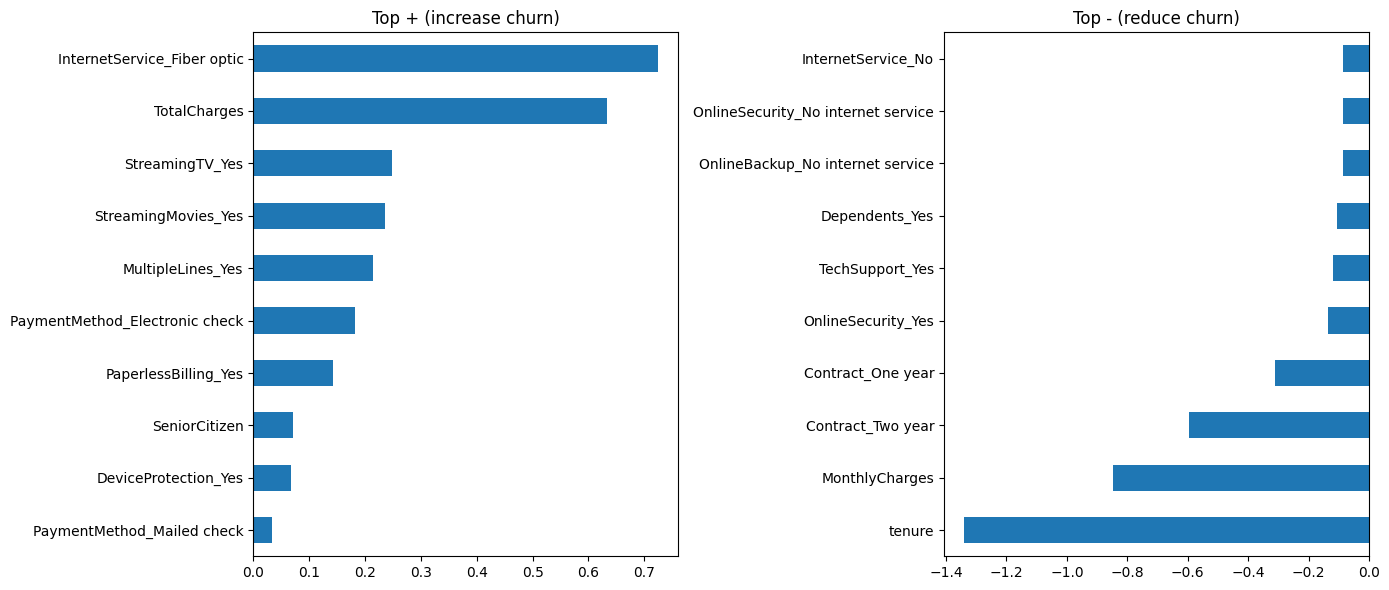

In [11]:
# Plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

top_pos.sort_values().plot(kind="barh", ax=axes[0], title="Top + (increase churn)")
top_neg.sort_values().plot(kind="barh", ax=axes[1], title="Top - (reduce churn)")

plt.tight_layout()
plt.show()


In [12]:
# Part 3 — Decision Trees + overfitting check (unconstrained vs pruned)
# Unconstrained tree (entropy) + report train/test accuracy
tree_uncon = DecisionTreeClassifier(criterion="entropy", random_state=42)
tree_uncon.fit(X_train_scaled, y_train)

train_acc_uncon = accuracy_score(y_train, tree_uncon.predict(X_train_scaled))
test_acc_uncon  = accuracy_score(y_test,  tree_uncon.predict(X_test_scaled))

train_acc_uncon, test_acc_uncon


(0.9987555555555555, 0.7277896233120114)

In [13]:
# Pruned tree (controlled complexity) + compare
tree_pruned = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)
tree_pruned.fit(X_train_scaled, y_train)

train_acc_pr = accuracy_score(y_train, tree_pruned.predict(X_train_scaled))
test_acc_pr  = accuracy_score(y_test,  tree_pruned.predict(X_test_scaled))

train_acc_pr, test_acc_pr


(0.7927111111111111, 0.775408670931059)

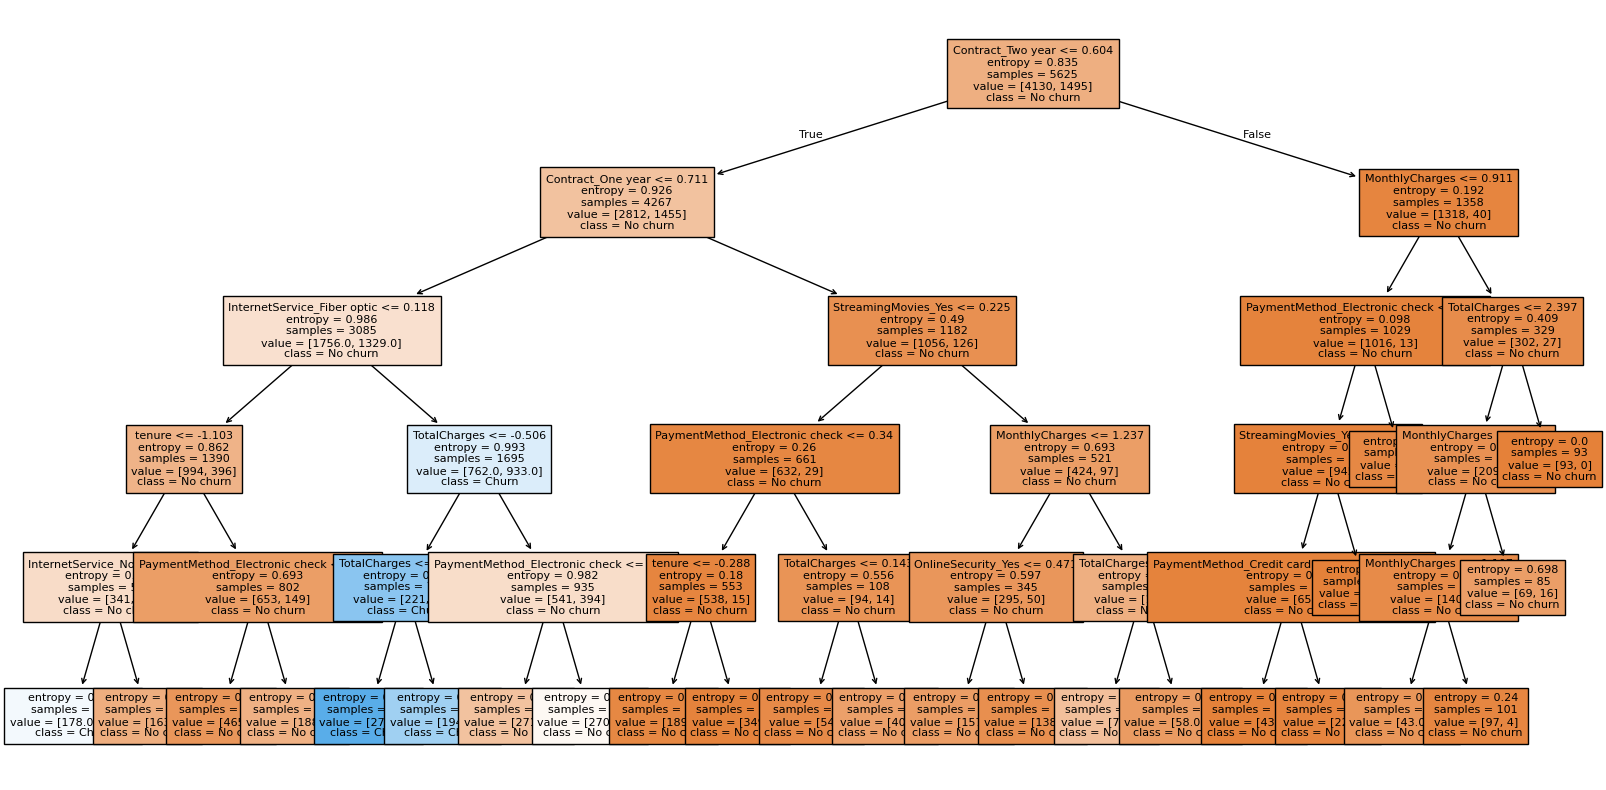

In [14]:
# visualize the pruned decision tree (interpret the rules)
plt.figure(figsize=(20, 10))
plot_tree(
    tree_pruned,
    feature_names=feature_names,
    class_names=["No churn", "Churn"],
    filled=True,
    fontsize=8
)
plt.show()


In [15]:
# Part 4 — Ensemble learning (Bagging + Boosting)
# Random Forest (Bagging)
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(n_jobs=-1, random_state=42)

In [16]:
# XGBoost (Boosting) with log-loss metric
!pip install xgboost


In [17]:
from xgboost import XGBClassifier

# train the model
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.08,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)
xgb.fit(X_train_scaled, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [18]:
# Part 5 — Final evaluation (all four models) + comparison table + ROC
# generate test predictions for all models
models = {
    "Logistic Regression": (log_reg, X_test_scaled),
    "Pruned Decision Tree": (tree_pruned, X_test_scaled),
    "Random Forest": (rf, X_test_scaled),
    "XGBoost": (xgb, X_test_scaled)
}

results = []
for name, (model, Xs) in models.items():
    y_pred = model.predict(Xs)
    y_proba = model.predict_proba(Xs)[:, 1]  # for ROC/AUC

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC": auc(*roc_curve(y_test, y_proba)[:2])
    })


In [19]:
# comparison table
results_df = pd.DataFrame(results).sort_values("Recall", ascending=False)
results_df


,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.803838,0.647590,0.574866,0.609065,0.835618
3,XGBoost,0.787491,0.616099,0.532086,0.571019,0.829639
2,Random Forest,0.788202,0.623377,0.513369,0.563050,0.815628
1,Pruned Decision Tree,0.775409,0.597973,0.473262,0.528358,0.819243


In [20]:
# pick the best recall model + confusion matrix (cost of missing churn)
best = results_df.iloc[0]["Model"]     # highest Recall
best_model = models[best][0]
y_pred_best = best_model.predict(models[best][1])

cm = confusion_matrix(y_test, y_pred_best)
cm


array([[916, 117],
       [159, 215]])

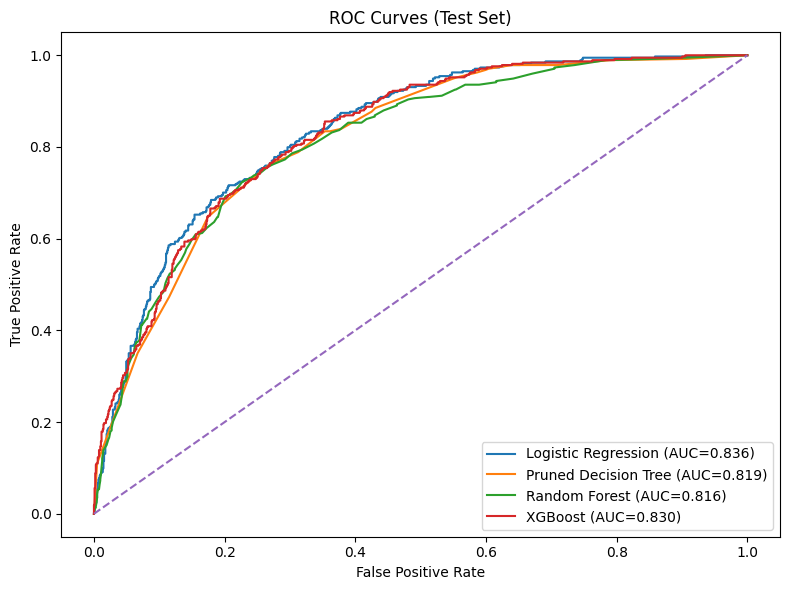

In [21]:
# ROC curves (all four on one plot) + AUCs
plt.figure(figsize=(8,6))

for name, (model, Xs) in models.items():
    y_proba = model.predict_proba(Xs)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "--")  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()
